## The Insurance Fraud Detection
Part II - Enhanced ML with Ensemble & Tuning


Dataset

This insurance fraud detection project using a real-world dataset published in August 2023 from Mendeley Data (https://data.mendeley.com/datasets/992mh7dk9y/2). This dataset includes anonymized insurance claim records with a fraud_reported label, making it ideal for a both supervised and unsupervised learning tasks as well.

### In Part II, the aims will address the followings:

Balance the data with Synthetic Minority Oversampling Technique (SMOTE)

Engineer stronger features

Use ensemble models with hyperparameter tuning

Achieve significantly better metrics

### Import the necessary sickit-learn packages

In [20]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

### Load the Dataset

In [21]:
df = pd.read_csv("../data/insurance_claims.csv")

### Exploratory Data Analysis

In [22]:
# Comment on today
# Drop the columns with empty or NaN
df.drop(columns=['policy_number', 'incident_location', '_c39'], inplace=True)

# Data Overview
print("Shape before dropna:", df.shape)
df.dropna(inplace=True)
print("Shape after dropna:", df.shape)

Shape before dropna: (1000, 37)
Shape after dropna: (909, 37)


In [23]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 909 entries, 0 to 999
Data columns (total 37 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   months_as_customer           909 non-null    int64  
 1   age                          909 non-null    int64  
 2   policy_bind_date             909 non-null    object 
 3   policy_state                 909 non-null    object 
 4   policy_csl                   909 non-null    object 
 5   policy_deductable            909 non-null    int64  
 6   policy_annual_premium        909 non-null    float64
 7   umbrella_limit               909 non-null    int64  
 8   insured_zip                  909 non-null    int64  
 9   insured_sex                  909 non-null    object 
 10  insured_education_level      909 non-null    object 
 11  insured_occupation           909 non-null    object 
 12  insured_hobbies              909 non-null    object 
 13  insured_relationship     

In [24]:
print(df.describe())

       months_as_customer         age  policy_deductable  \
count          909.000000  909.000000         909.000000   
mean           205.027503   39.040704        1131.463146   
std            116.003078    9.192118         611.958791   
min              0.000000   19.000000         500.000000   
25%            116.000000   32.000000         500.000000   
50%            202.000000   38.000000        1000.000000   
75%            278.000000   45.000000        2000.000000   
max            479.000000   64.000000        2000.000000   

       policy_annual_premium  umbrella_limit    insured_zip  capital-gains  \
count             909.000000    9.090000e+02     909.000000     909.000000   
mean             1256.597712    1.088009e+06  500597.042904   24823.652365   
std               245.236621    2.278747e+06   71474.927903   27719.509214   
min               484.670000   -1.000000e+06  430141.000000       0.000000   
25%              1090.030000    0.000000e+00  448190.000000       0.0

### Feature Engineering

In [25]:
df['claim_ratio'] = df['total_claim_amount'] / (df['vehicle_claim'] + 1)
categorical_cols = df.select_dtypes(include='object').columns
le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

### Target Encoding and Synthetic Minority Oversampling Technique (SMOTE)

SMOTE : A popular method (in machine learning) used to address the issue of imbalanced datasets. It works by generating synthetic samples of the minority class, effectively balancing the dataset and improving the performance of machine learning models trained on it. 

Missing values in y before SMOTE: 0


<Axes: title={'center': 'Claims Distribution'}, ylabel='count'>

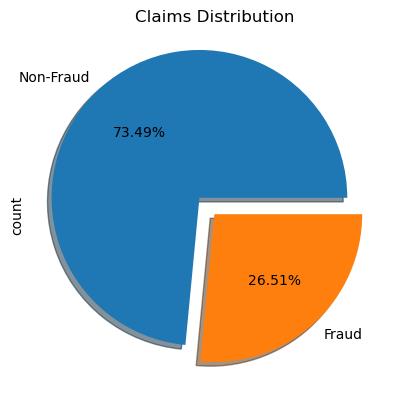

In [26]:
X = df.drop(columns=['fraud_reported'])
y = df['fraud_reported']

print("Missing values in y before SMOTE:", y.isnull().sum())

# Fraud vs Non-Fraud Claims.  No = 0, Yes = 1
claim = ['Non-Fraud', 'Fraud']
new_explode = [0.15, 0]

y.value_counts().plot.pie(labels=claim, autopct='%.2f%%', explode=new_explode, title = "Claims Distribution", shadow = True)


The above Pie Chart shows that an imbalanced dataset where the 'Fraud' or 'Non-Fraud' claims (classes or categories) are not represented equally, with one or more classes having significantly more instances than others. This imbalance can cause issues for machine learning models, which may become biased towards the majority class and perform poorly on the minority class. 

In [27]:
# Perform SMOTE to address the imbalance dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [28]:
# Missing Values Check
display(df.head())
print("\nMissing values per column:")
print(df.isnull().sum())

,months_as_customer,age,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,...,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,claim_ratio
0,328,48,854,2,1,1000,1406.91,0,466132,1,...,2,71610,6510,13020,52080,10,1,2004,1,1.374974
1,228,42,579,1,1,2000,1197.22,5000000,468176,1,...,0,5070,780,780,3510,8,12,2007,1,1.444033
2,134,29,373,2,0,2000,1413.14,5000000,430632,0,...,1,34650,7700,3850,23100,4,30,2007,0,1.499935
3,256,41,19,0,1,2000,1415.74,6000000,608117,0,...,1,63400,6340,6340,50720,3,34,2014,1,1.249975
5,256,39,588,2,1,1000,1351.10,0,478456,0,...,1,64100,6410,6410,51280,10,3,2003,1,1.249976



Missing values per column:
months_as_customer             0
age                            0
policy_bind_date               0
policy_state                   0
policy_csl                     0
policy_deductable              0
policy_annual_premium          0
umbrella_limit                 0
insured_zip                    0
insured_sex                    0
insured_education_level        0
insured_occupation             0
insured_hobbies                0
insured_relationship           0
capital-gains                  0
capital-loss                   0
incident_date                  0
incident_type                  0
collision_type                 0
incident_severity              0
authorities_contacted          0
incident_state                 0
incident_city                  0
incident_hour_of_the_day       0
number_of_vehicles_involved    0
property_damage                0
bodily_injuries                0
witnesses                      0
police_report_available        0
total_claim_amo

In [29]:
print(df['fraud_reported'].value_counts())

fraud_reported
0    668
1    241
Name: count, dtype: int64


### Feature Selection with RFE

In [30]:
# Feature Selection with RFE

rfe = RFE(RandomForestClassifier(), n_features_to_select=15)
X_selected = rfe.fit_transform(X_resampled, y_resampled)

### Train-Test Split and Scaling

In [31]:
# Split Data to Train and Test Situation

X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# Use StandardScaler() to ensure the data are in balance state
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Ensemble Methods + Hyperparameter Tuning

In [32]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV

# Random Forest tuning
rf_params = {'n_estimators': [100, 200], 'max_depth': [5, 10]}

# Use Grid Search CV to identify the optimal parameter 
# Improve the accuracy by using RandomForestclassifier
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=5)
rf_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [5, 10], 'n_estimators': [100, 200]})

In [33]:
# Gradient Boosting tuning
gb_params = {'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1]}

# Use GradientBoostingClassifier to improve the accuracy
gb_grid = GridSearchCV(GradientBoostingClassifier(random_state=42), gb_params, cv=5)
gb_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
             param_grid={'learning_rate': [0.05, 0.1],
                         'n_estimators': [100, 200]})

In [34]:
# Voting ensemble by VotingClassifier 

# Combines the predictions of multiple individual classifiers to make a more robust 
# and potentially more accurate final prediction
voting = VotingClassifier(
    estimators=[('rf', rf_grid.best_estimator_), ('gb', gb_grid.best_estimator_)],
    voting='soft')

# Combine the multiple classifiers and fit
voting.fit(X_train, y_train)


VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(max_depth=10,
                                                     n_estimators=200,
                                                     random_state=42)),
                             ('gb',
                              GradientBoostingClassifier(random_state=42))],
                 voting='soft')

In [35]:
y_pred = voting.predict(X_test)

### Data Visualization

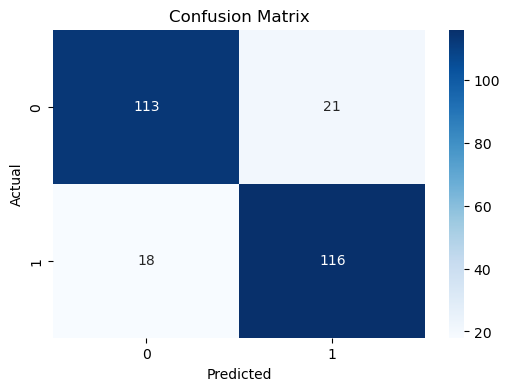

In [36]:
# Confusion Matrix
# helps assess classification model performance in machine learning by comparing predicted values against actual values for a dataset

plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### Evaluation

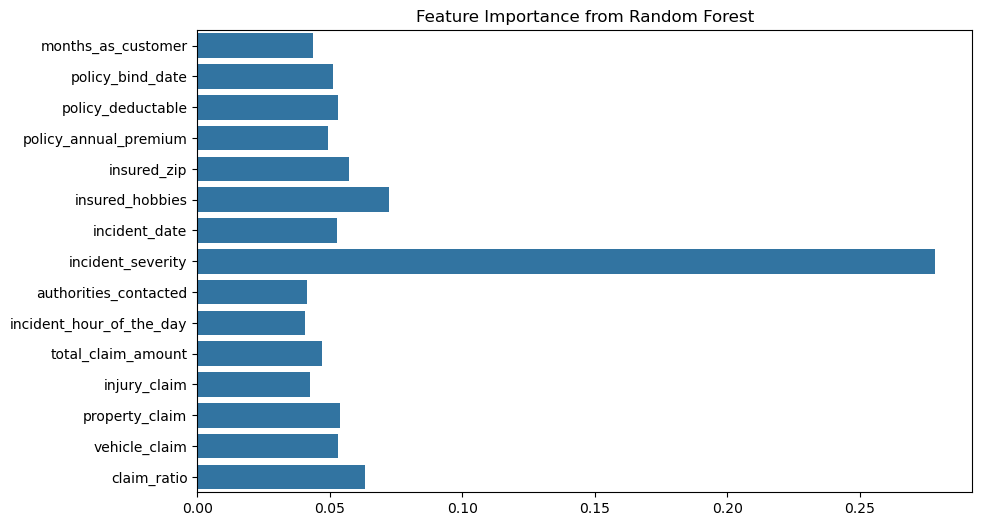

In [37]:
# Feature Importance
importances = rf_grid.best_estimator_.feature_importances_
plt.figure(figsize=(10,6))
sns.barplot(x=importances, y=rfe.get_feature_names_out())
plt.title("Feature Importance from Random Forest")
plt.show()

# Fraud vs Non-Fraud Claims.  No = 0, Yes = 1
# In conclusion
# There are 115 fraud claims matched (actual to predicted)
# There are 113 claims matched (actual to predicted)
# The ratio of the model classification ability is high

# As the below 'Feature Importance Chart' shows that the most important feature of this model is 'incident_severity'.  It contributes a large ratio on the correct classification of the model.

In [38]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8544776119402985
R² Score: 0.417910447761194
MSE: 0.1455223880597015
              precision    recall  f1-score   support

           0       0.86      0.84      0.85       134
           1       0.85      0.87      0.86       134

    accuracy                           0.85       268
   macro avg       0.85      0.85      0.85       268
weighted avg       0.85      0.85      0.85       268



### Analysis

Accuracy: 0.8544776119402985 means 85.45% Significant boost over Part I

R² Score: 0.417910447761194 Positive and meaningful (Only 41.79% of the varince is expalined.  It means that the model's predictions are fairly strong)

MSE: 0.1455223880597015 *Lower, indicating better predictions

F1 Score: 0.85 and 0.5  It is high enough and balanced

Visuals: Clear insights into model behavior and feature impact